In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
%matplotlib inline

In [2]:
#specify data source 
datasource = 'LocusEnergy'

In [3]:
zipcode = '08641'

In [4]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis\PVreadingsStudies\main'
#we can choose which data to look at.
dataDir = mainDir + '/data/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [5]:
data = pd.read_csv(dataDir +'/training_data_fitted.csv')
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

dsummary = pd.read_csv(outputDir+"/fitsummary.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef.csv")

In [6]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01,-355,NaN,False,False,False,5.070652


In [7]:
FullModelCoef[:1]

,DBW,c1,c2,c3,c4,c5,c6,c7,c8,c9,c0,c10
0,0,0.435674,0.52322,0.750568,0.761555,0.794036,0.838259,0.83471,0.657754,0.646756,0.156387,0.156051


Here we define power ratio, $r$, for each power reading. We add shift to avoid infinity.

In [8]:
shift = 0.01
data['r'] = (data.power+shift)/(data.mpower+shift)

In [9]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r
0,2013-01-01 07:30:00,1.11014,-301.362934,NaN,5,64.71819,-0.999743,-355,0.154078,NaN


Here we number steps from sun rise to sun set. Don't need in for now.

In [10]:
'''
data['StepOfDay'] = float('NaN')
for DateOfInterest in list(dsummary.Date):
    bool_list = d.tsLocal.map(lambda x: x.date() == DateOfInterest)
    indexlist = [i for i, elem in enumerate(bool_list) if elem]
    data['StepOfDay'].loc[indexlist] = range(0,sum(bool_list))
    '''
[0]

[0]

# Validity of maximum power envelope

It is worth to look how well maximum power envelope works. Let's look at the histogram and percentile of $r=1.0$

(array([ 1669.,  2851.,  3055.,  3951.,  5204.,  7878.,  2288.,   373.,
          146.,    55.]),
 array([ 0.11162029,  0.25743228,  0.40324427,  0.54905625,  0.69486824,
         0.84068023,  0.98649221,  1.1323042 ,  1.27811619,  1.42392817,
         1.56974016]),
 <a list of 10 Patch objects>)

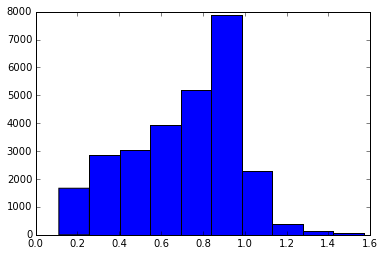

In [11]:
plt.hist(list(data['r'].dropna()))

In [12]:
scipy.stats.percentileofscore(data['r'].dropna(),1.0), np.percentile(data['r'].dropna(),95), np.max(data['r'])

(91.470695303967958, 1.0375749147712272, 1.5697401616234494)

This means that we are 91% confidence that maximum envelope is maximum. To ensure maximum envelope is really maximum, we can scale maximum envelope by 1.03 to achieve 95% confidence or 1.57 to achieve 100%.

(array([    43.,    287.,    905.,   1449.,   1757.,   2217.,   2956.,
          4843.,  11532.,   1481.]),
 array([-0.91021858, -0.8074452 , -0.70467181, -0.60189843, -0.49912504,
        -0.39635166, -0.29357828, -0.19080489, -0.08803151,  0.01474188,
         0.11751526]),
 <a list of 10 Patch objects>)

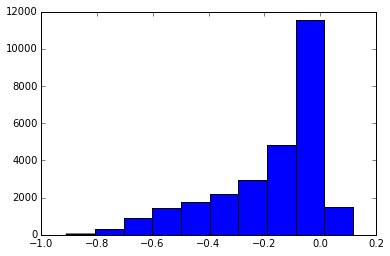

In [13]:
plt.hist(list((data['power']-data['mpower']).dropna()))

In [14]:
[scipy.stats.percentileofscore((data['power']-data['mpower']).dropna(),0), np.percentile((data['power']-data['mpower']).dropna(),95),
np.max((data['power']-data['mpower']).dropna())]

[91.470695303967958, 0.01659359246507517, 0.11751526329069123]

This means that we are 91% confidence that maximum envelope is maximum. To ensure maximum envelope is really maximum, we can shift maximum envelope up by 0.02 to achieve 95% confidence or 0.12 to achieve 100%.